# Prediction of olfactory receptor (OR) responses to odorants

This notebook trains `Random Forest` classification models to predict the response of human and mouse ORs to four odorants.   
This is done in four steps:  
1. load & transform training data;
2. train 5 independent models with 5 subsets of residues, and compare their predictivity with a non-predictive control model;
3. build a final model with the best residue subset above, then predict and rank new ORs by their probability to respond to the odorants;
4. evaluate the prediction with *in vitro* data.

The training data are **mostly** from the *in vitro* assays in the following publications:
[Saito et al. Sci Signal (2009) 2:ra9](https://stke.sciencemag.org/content/2/60/ra9), 
[Mainland et al. Nat Neurosci (2014) 17:114–120](https://www.nature.com/articles/nn.3598#citeas), 
[Mainland et al. Sci Data (2015) 2:150002](https://www.nature.com/articles/sdata20152), 
[Jiang et al. Nat Neurosci (2015) 18:1446-1454](https://www.nature.com/articles/nn.4104), 
[Kida et al. Nat Commun (2018) 9:4556](https://www.nature.com/articles/s41467-018-06806-w), 
[Jones et al. Cell Syst (2019) 8:254-260](https://doi.org/10.1016/j.cels.2019.02.009).

## Software requirements

- `R` version 3.5 or higher is recommended.  
- Required R packages: `caret`, `MLmetrics`, `e1071`, `bio3d`, `stringr`, `ggpubr`, `gridExtra`  
It is recommended to install the packages with `Conda` (e.g. *conda install r-MLmetrics*, *conda install -c conda-forge r-ggpubr*) prior to using this notebook.  
Alternative package installtion by `install.packages` (see below) may **fail**.  

### Install & load required packages

In [1]:
packages <- c("caret", "ROCR", "MLmetrics", "e1071", "bio3d", "stringr", "ggpubr", "gridExtra")
missing <- !unlist(lapply(packages, require, character.only = TRUE))

if (any(missing)){
    install.packages(packages[missing], dependencies = TRUE, repos='http://cran.us.r-project.org')
    lapply((packages[missing]), library, character.only = TRUE)
    }

Loading required package: caret

Loading required package: lattice

Loading required package: ggplot2

Loading required package: ROCR

Loading required package: MLmetrics


Attaching package: ‘MLmetrics’


The following objects are masked from ‘package:caret’:

    MAE, RMSE


The following object is masked from ‘package:base’:

    Recall


Loading required package: e1071

Loading required package: bio3d

Loading required package: stringr

Loading required package: ggpubr

Loading required package: gridExtra



## 1. Training data  
- **OR data**: pre-aligned sequences of human & mouse ORs, in which each amino acid will be converted to three physicochemical scores (`Composition`, `Polarity`, `Volumn`);  
- **Odorant data**: 244 odorants represented by molecular descriptors, which have been pre-calculated with [Dragon 7.0](https://chm.kode-solutions.net/products_dragon.php);  
- Finally, merge the above data into a **proteochemometric** presentation of OR-odorant pairs, labeled by **positive** (if the OR responds to the odorant *in vitro* in a dose-dependent manner) or **negative** (no significant response observed *in vitro*). 

### 1.1 Convert OR sequence alignment to physicochemical features

Load the sequence alignment of human and mouse ORs, including some mutants. For this study, only the 7-transmembrane domain (7TM) and the extracellular loop 2 (ECL2) are included in the alignment, which are numbered according to the Ballesteros-Weinstein scheme. 

In [2]:
# Ballesteros-Weinstein numbering scheme
TM_ECL2 <- c(seq(1.32, 1.65, 0.01), # TM1
             seq(2.39, 2.67, 0.01), # TM2
             seq(3.25, 3.55, 0.01), # TM3
             seq(4.40, 4.61, 0.01), # TM4
             paste("EClII", 1:23, sep=""), # ECL2
             seq(5.37, 5.65, 0.01), # TM5
             seq(6.32, 6.56, 0.01), # TM6
             seq(7.35, 7.55, 0.01)) # TM7

seq <- read.fasta("Response_to_odorants/Data/Sequence_alignment.fa")
datOR <- as.data.frame(seq$ali)
colnames(datOR) <- paste0("Res", TM_ECL2)

#### Take a look at the first 5 residues of 3 ORs:

In [3]:
datOR[1:3, 1:5]

,Res1.32,Res1.33,Res1.34,Res1.35,Res1.36
,<fct>,<fct>,<fct>,<fct>,<fct>
hOR10A2,Q,S,L,L,F
hOR10A3,Q,V,Q,L,F
hOR10A4,Q,A,L,L,F


Remove gaps from the alignment, then convert each amimo acid to its physicochemical scores (features): `Composition`, `Polarity`, `Volumn` [Grantham, Science (1974) 185:862-4](https://science.sciencemag.org/content/185/4154/862)

In [4]:
# Remove columns that contain gaps in > 1% of the ORs 
datOR <- datOR[, colSums(datOR == "-") < nrow(datOR)*0.01]

# Remove ORs that still contain gaps
datOR <- datOR[rowSums(datOR == "-") == 0, ]

# Convert amino acids to physicochemical features
source("Functions/sequence2features_Grantham1974.R")
datOR <- cbind(residProps(datOR, "Vol"),
               residProps(datOR, "Comp"),
               residProps(datOR, "Polar"))
datOR <- datOR[, sort(names(datOR))]

cat("The first 5 residues of 3 ORs after conversion:")
datOR[1:3,1:15]

The first 5 residues of 3 ORs after conversion:

,Res1.32Comp,Res1.32Polar,Res1.32Vol,Res1.34Comp,Res1.34Polar,Res1.34Vol,Res1.35Comp,Res1.35Polar,Res1.35Vol,Res1.36Comp,Res1.36Polar,Res1.36Vol,Res1.37Comp,Res1.37Polar,Res1.37Vol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hOR10A2,0.89,10.5,85,0.00,4.9,111,0,4.9,111,0,5.2,132,0.00,4.9,111
hOR10A3,0.89,10.5,85,0.89,10.5,85,0,4.9,111,0,5.2,132,0.74,9.0,3
hOR10A4,0.89,10.5,85,0.00,4.9,111,0,4.9,111,0,5.2,132,0.00,4.9,111


In [5]:
# Remove low variance features
near_zero <- nearZeroVar(datOR[, ], freqCut = 95/5, saveMetrics = TRUE)
low_variance_cols <- near_zero[(near_zero$zeroVar == TRUE) | (near_zero$nzv == TRUE), ]
drops <- rownames(low_variance_cols)
datOR <- datOR[, !(names(datOR) %in% drops)]

# Remove highly correlated features
correlationMatrix <- cor(datOR)
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff = 0.8)
datOR <- datOR[, -highlyCorrelated]

cat("The alignment now contains", nrow(datOR), "ORs and", ncol(datOR), "features.")

The alignment now contains 1727 ORs and 398 features.

In [6]:
# Extract training set ORs
trainOR <- read.csv('Response_to_odorants/Data/TrainingSet_OR-odorant_pairs/trainORs_labeled.csv',
                    stringsAsFactors = FALSE)
cat("The training set contains", nrow(trainOR), "ORs, including", sum(trainOR$Label == "Orphan"), "orphan ORs.")

datTrainOR <- datOR[rownames(datOR) %in% trainOR$OR, ]
trainOR <- trainOR[trainOR$OR %in% rownames(datTrainOR), ]

The training set contains 708 ORs, including 318 orphan ORs.

### 1.2 Molecular descriptors of odorants  
  
Load pre-calculated molecular descriptors (features) of 244 odorants.  
Each odorant has a unique PubChem CID, a SMILES string and 3850 features:

In [7]:
allOdor <- read.csv("Response_to_odorants/Data/Odorants_features.csv", header = 1,
                    colClasses=c('character', 'character', 'character', replicate(3850, 'numeric')))
allOdor[1:3, 1:10]

,Odorant,CID,SMILES,Feat1,Feat2,Feat3,Feat4,Feat5,Feat6,Feat7
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,phenylmethanol,244,OCc1ccccc1,108.15,6.759,9.822,15.862,10.500,17.870,0.614
2,benzaldehyde,240,O=Cc1ccccc1,106.13,7.581,9.295,13.978,9.739,15.455,0.664
3,Diphenyl ether,7583,O(c1ccccc1)c2ccccc2,170.22,7.401,15.349,22.745,16.262,25.285,0.667


The training set will contain the 4 odorants of interest, as well as their analogs.  
To to find their analogs, we use a pre-calculated chemical similarity (`Tanimono coefficient`) matrix between the 244 odorants.

In [8]:
# Load the chemical similarity matrix
tanimoto <- read.csv('Response_to_odorants/Data/Odorants_similarity.csv', row.names = 1)

# PubChem CIDs of the 4 odorants of interest
testCIDs <- c(439570, 7410, 323, 68110)

# Tanimoto coeeficient > 0.6 are considered similar
numextract <- function(string){ 
  as.numeric(str_extract(string, "\\-*\\d+\\.*\\d*"))
}

trainCIDs <- numextract(colnames(tanimoto)[colSums(tanimoto[paste0('CID', testCIDs), ] > 0.6) > 0])

cat("The training set contains: \n\n", length(testCIDs), "odorants of interest")
allOdor[allOdor$CID %in% testCIDs, 1:3]

cat("and their", length(setdiff(trainCIDs, testCIDs)), "analogs:")
allOdor[allOdor$CID %in% setdiff(trainCIDs, testCIDs), 1:3]

The training set contains: 

 4 odorants of interest

,Odorant,CID,SMILES
,<chr>,<chr>,<chr>
128,4-chromanone,68110,O=C1CCOc2ccccc12
186,coumarin,323,O=C1Oc2ccccc2C=C1
197,acetophenone,7410,CC(=O)c1ccccc1
223,R-(-)-Carvone,439570,CC1=CC[C@H](CC1=O)C(=C)C


and their 6 analogs:

,Odorant,CID,SMILES
,<chr>,<chr>,<chr>
98,S-(+)-carvone,16724,CC1=CC[C@@H](CC1=O)C(=C)C
144,(R)-(+)-limonene,440917,CC1=CC[C@@H](CC1)C(=C)C
145,(S)-(-)-limonene,439250,CC1=CC[C@H](CC1)C(=C)C
157,Isolimonene,22831540,CC(=C)C1CCC(=CC1)C
201,methyl benzoate,7150,COC(=O)C1=CC=CC=C1
243,4-Hydroxycoumarin,54682930,C1=CC=C2C(=C1)C(=CC(=O)O2)O


In [9]:
# Extract the molecular features of the training set odorants.  
datOdor <- allOdor[allOdor$CID %in% trainCIDs, ]
CID <- datOdor$CID
datOdor <- datOdor[, -c(1:3)]

# Removes columns containing NA
datOdor <- datOdor[, colSums(is.na(datOdor)) == 0]

# Remove low variance features
near_zero <- nearZeroVar(datOdor[, ], freqCut = 95/5, saveMetrics = TRUE)
low_variance_cols <- near_zero[(near_zero$zeroVar == TRUE) | (near_zero$nzv == TRUE), ]
drops <- rownames(low_variance_cols)
datOdor <- datOdor[, !(names(datOdor) %in% drops)]

# Remove highly correlated features
correlationMatrix <- cor(datOdor)
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff=0.75)
datOdor <- datOdor[, -highlyCorrelated]
datOdor <- cbind(CID, datOdor)

cat(ncol(datOdor), "features remained:")
datOdor

8 features remained:

,CID,Feat805,Feat824,Feat1032,Feat1066,Feat1099,Feat1152,Feat1517
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
98,16724,1.278,0.004,0.044,1.108,0.049,3.552,0.68
128,68110,1.258,0.017,-0.057,1.141,0.046,3.370,0.86
144,440917,1.272,0.026,0.091,1.071,0.045,3.476,0.68
145,439250,1.272,0.026,0.091,1.071,0.045,3.476,0.68
157,22831540,1.272,0.026,0.091,1.071,0.045,3.476,0.68
186,323,1.279,0.018,0.153,1.063,0.031,3.463,0.00
197,7410,1.286,0.015,0.030,1.233,0.049,3.461,0.00
201,7150,1.236,0.011,0.080,0.941,0.040,3.555,0.00
223,439570,1.278,0.004,0.044,1.108,0.049,3.552,0.68


### 1.3 Merge OR and odorant data into OR-odorant pairs  
For each odorant, merge it with all the ORs that have been tested on it *in vitro*, then label each pair with **positive** or **negative**.

In [10]:
allPairs <- read.csv("Response_to_odorants/Data/TrainingSet_OR-odorant_pairs/OR-odorant_pairs.csv",
                     stringsAsFactors = FALSE)

datPos <- data.frame()
datNeg <- data.frame()

for (cid in trainCIDs){
    # merge responsive pairs
    pos <- allPairs$Gene[allPairs$CID == cid & allPairs$Responsive == 1]
    if (length(pos) > 0){
        datP <- merge(datTrainOR[rownames(datTrainOR) %in% pos, ], datOdor[datOdor$CID == cid, -1])
        rownames(datP) <- paste(rownames(datTrainOR)[rownames(datTrainOR) %in% pos], cid, sep = "_")
        datPos <- rbind(datPos, datP)
    }
    
    # merge non-responsive pairs
    neg <- allPairs$Gene[allPairs$CID == cid & allPairs$Responsive == 0]
    if (length(neg) > 0){
        datN <- merge(datTrainOR[rownames(datTrainOR) %in% neg, ], datOdor[datOdor$CID == cid, -1])
        rownames(datN) <- paste(rownames(datTrainOR)[rownames(datTrainOR) %in% neg], cid, sep = "_")
        datNeg <- rbind(datNeg, datN)
    }
}

# Add a column of class labels
datPos$Label <- "positive"
datNeg$Label <- "negative"

data <- rbind(datPos, datNeg)
data$Label <- factor(data$Label, levels = c("positive", "negative"))

cat("The final training set contains", nrow(data), "OR-odorant pairs:")
table(data$Label)

The final training set contains 1065 OR-odorant pairs:


positive negative 
     202      863 

## 2. Model training  
Train 5 independent models, starting from 5 heuristic subsets of residues in the OR sequences:
- ***poc17***, 17 residues outlining the odorant-binding pocket
- ***poc20***, 20 residues outlining the odorant-binding pocket (*poc17* + 3 peripheral residues)
- ***poc27***, *poc20* + 7 more peripheral residues
- ***poc60***, 60 residues in an extended pocket region
- ***TM191***, 191 residues in the transmembrane (TM) domain

As control, a non-predictive model will be built with pseudo-sequences of 60 random residues.

In [11]:
subsets <- c('poc17', 'poc20', 'poc27', 'poc60', 'TM191', 'random')

# Ballesteros-Weinstein numbers of 5 heuristic subsets of residues
poc17 <- c(2.53,  # TM2
           3.29, 3.30, 3.32, 3.33, 3.36, 3.37, 3.38, # TM3
           5.42, 5.43, 5.46, 5.47, # TM5
           6.48, 6.51, 6.52, 6.55, #TM6
           7.42) # TM7

poc20 <- c(2.53, 2.54, # TM2
           3.29, 3.30, 3.32, 3.33, 3.36, 3.37, 3.38, # TM3
           5.38, 5.39, 5.42, 5.43, 5.46, 5.47, # TM5
           6.48, 6.51, 6.52, 6.55, #TM6
           7.42) # TM7

poc27 <- c(2.53, 2.54, # TM2
           3.29, 3.30, 3.31, 3.32, 3.33, 3.36, 3.37, 3.38, 3.40, 3.41, # TM3
           4.56, # TM4
           5.37, 5.38, 5.39, 5.42, 5.43, 5.46, 5.47, # TM5
           6.44, 6.48, 6.51, 6.52, 6.55, #TM6
           7.38, 7.42) # TM7

poc60 <- c(2.53,2.54, 2.57, 2.61, # TM2
           seq(3.25, 3.41, 0.01), # TM3
           4.52, 4.53, 4.56, 4.57, 4.60, # TM4
           seq(5.35, 5.51, 0.01), # TM5
           6.44, 6.45, seq(6.47, 6.56, 0.01), # TM6
           7.35, 7.38, 7.39, 7.41, 7.42) # TM7

TM191 <- c(seq(1.32, 1.65, 0.01), # TM1
           seq(2.39, 2.67, 0.01), # TM2
           seq(3.25, 3.55, 0.01), # TM3
           seq(4.40, 4.61, 0.01), # TM4
           seq(5.37, 5.65, 0.01), # TM5
           seq(6.32, 6.56, 0.01), # TM6
           seq(7.35, 7.55, 0.01)) # TM7

# for the non-predictive control model
random <- sample(TM191, 60)

### 2.1 5-fold cross validation  
**Note:** The validation set contains only the 4 odorants of interest and not their analogs. The final model will serve the 4 odorants and should not be evaluated on the analogs. The analogs are included to enhance the model training and and should remain in the training set. 

In [41]:
# Index the pairs containing the 4 odorants of interest
val_idx <- unlist(lapply(paste0("_", testCIDs), function(x) grep(x, rownames(data))))
valPairs <- rownames(data)[val_idx]
                         
# Stratify into 5 folds (as validation sets) for cross validation
folds <- createFolds(data[val_idx, ]$Label, 5, list = TRUE)

In [13]:
# Function to extract metrics from a confusion matrix
getMetrics <- function(prediction, reference, positive){
    # confusion matix
    p <- confusionMatrix(prediction, reference, positive = positive)
    
    TP <- p$table[1]
    TN <- p$table[4]
    FP <- p$table[3]
    FN <- p$table[2]

    # Matthews correlation coefficient (MCC)
    mcc_num <- (TP*TN - FP*FN)
    mcc_den <- as.double((TP+FP))*as.double((TP+FN))*as.double((TN+FP))*as.double((TN+FN))
    MCC <- mcc_num/sqrt(mcc_den)
    
    metrics=c(round(c(MCC, p$byClass[c(5,6,2)]), 2), TP, TN, FP, FN)
    names(metrics)=c("MCC", "Precision", "Recall", "Specificity", "TP", "TN", "FP", "FN")
    return(metrics)
}

In [ ]:
# Train 6 models with the 6 residue subsets
for (subset in subsets){
    
    # Extract the data columns belonging to the residue subset, as well as the odorant columns and the response label 
    ResCols <- paste0("Res", as.vector(outer(get(subset), c("Comp", "Polar", "Vol"), paste0)))
    datTrain <- data[, names(data) %in% c(ResCols, names(datOdor), "Label")]
    
    # for the control model, generate pseudo-sequences by randomizing the residues and the responses to the odorants
    if (subset == "random"){
        pseudoSeq <- data[, names(data) %in% ResCols]
        pseudoSeq <- pseudoSeq[sample(nrow(pseudoSeq)), sample(ncol(pseudoSeq))]
        datTrain <- cbind(pseudoSeq, data[, names(data) %in% c(names(datOdor), "Label")])
    } 
    
    # An empty matrix to summarize the metrics of model performance
    metrics <- c("MCC", "Precision", "Recall", "Specificity", "TP", "TN", "FP", "FN")
    perfSum <- matrix(nrow = 5, ncol = length(metrics))
    colnames(perfSum) <- metrics
    rownames(perfSum) <- paste("Fold", 1:5, sep="_")
    
    # 5-fold cross validation
    for (i in 1:5){
        # Split training & validation sets
        valSet <- datTrain[rownames(datTrain) %in% valPairs[unlist(folds[i])], ]
        trainingSet <- datTrain[! rownames(datTrain) %in% valPairs[unlist(folds[i])], ]
        
        # Center & scale data
        preProc <- preProcess(trainingSet, method = c("center", "scale"))
        trainingProc <- predict(preProc, trainingSet)
        valProc <- predict(preProc, valSet)
        
        # Parameter tuning using nested 5-fold cross validation
        control <- trainControl(classProbs = TRUE, 
                            method = "cv", 
                            number = 5,
                            summaryFunction = prSummary)
        grid <- expand.grid(.mtry = seq(ncol(trainingProc)/2, ncol(trainingProc)-1, length.out= 5)) 
        
        # Train a random forest model with the tuned parameters
        mod_RF <- train(data = trainingProc, Label ~ . , 
                        method="rf", ntree = 2001,
                        metric="Precision",
                        tuneGrid = grid,
                        trControl=control)
        
        # Use the model to predicte the response probability of the OR-odorant pairs in the validation set
        probability <- predict(mod_RF, valProc, type = "prob")
        
        # Classifiy probability > 0.5 as "positive", equivalent to predict(mod_fit, newdata = valProc)
        predClass <- factor(ifelse(probability$positive > 0.5, "positive", "negative"),
                              levels = c("positive", "negative"))
        
        # Summarize the model performance on the validation set
        perfSum[i,] <- getMetrics(predClass, valProc$Label, positive = "positive")
    }
    
    # Mean, SD & SEM of the performance summary
    perfSum <- rbind(perfSum, Mean = round(colMeans(perfSum), 2), SD =round(apply(perfSum, 2, sd), 2))
    perfSum <- rbind(perfSum, SEM =round(perfSum["SD", ]/sqrt(5), 2))
    cat("\nPerformance summary of model", subset, "\n")
    print(perfSum)
    
    # Output  to file
    write.table(perfSum, paste0("Response_to_odorants/Cross_validation/", subset, ".tsv"), sep = "\t", quote = FALSE)
}

### Baseline: machine learning *vs* statistics
How good are the machine learning models, really? How much can we get simply from statistical inferences?
Assuming (naively) that the probability for an OR-odorant pair to be responsive is the average of the OR's responsiveness to the other odorants and the odorant's responsiveness to the other ORs. That is to say, that promiscuous ORs and odorants have high probabilities to response to one another. This probability draws a baseline to evaluate the performance of the above `Random Forest` models.

In [16]:
# Responsiveness of each OR in the training set
resp_OR <- table(allPairs$Gene[allPairs$Responsive==1])
# Responsiveness of each odorant in the training set
resp_odor <- table(allPairs$CID[allPairs$Responsive==1])
# Average the responsiveness of each OR-odorant pair
combi <- merge(names(resp_OR), names(resp_odor))
names(combi) <- c("OR", "odorant")
for (i in 1:nrow(combi)){
    combi$resp_pair[i] <- mean(resp_OR[names(resp_OR) == combi$OR[i]], resp_odor[names(resp_odor) == combi$odorant[i]])
}

# Normalize to obtain statistical probabilities
norm01 <- function(x){(x-min(x))/(max(x)-min(x))} # a normalization function 
combi$stat_prob <- round(norm01(combi$resp_pair), 2)
rownames(combi) <- paste(combi$OR, combi$odorant, sep = '_')
cat("First rows of the baseline:")
head(combi)
cat("...")

First rows of the baseline:

,OR,odorant,resp_pair,stat_prob
,<fct>,<fct>,<int>,<dbl>
hOR10A6_179,hOR10A6,179,2,0.01
hOR10A6_L287P_179,hOR10A6_L287P,179,1,0.00
hOR10A6_V140P_L287P_179,hOR10A6_V140P_L287P,179,1,0.00
hOR10C1_F60L_P174Q_M246V_179,hOR10C1_F60L_P174Q_M246V,179,1,0.00
hOR10G3_179,hOR10G3,179,2,0.01
hOR10G3_S73G_179,hOR10G3_S73G,179,4,0.04


...

In [42]:
# Predictivity of the baseline model during 5-fold cross validation
metrics <- c("MCC", "Precision", "Recall", "Specificity", "TP", "TN", "FP", "FN")
perfSum <- matrix(nrow = 5, ncol = length(metrics))
colnames(perfSum) <- metrics
rownames(perfSum) <- paste("Fold", 1:5, sep="_")

# 5-fold cross validation
for (i in 1:5){
    # Split training & validation sets
    valSet <- data[rownames(data) %in% valPairs[unlist(folds[i])], ]
    # Baseline probabilities
    probability <- combi$stat_prob[match(rownames(valSet), rownames(combi))]
    probability[is.na(probability)] <- 0
    # Classifiy probability > 0.5 as "positive", equivalent to predict(mod_fit, newdata = valProc)
    predClass <- factor(ifelse(probability > 0.5, "positive", "negative"),
                        levels = c("positive", "negative"))
  
    # Summarize the model performance on the validation set
    perfSum[i,] <- getMetrics(predClass, valSet$Label, positive = "positive")
}

# Mean, SD & SEM of the performance summary
perfSum[is.na(perfSum)] <- 0
perfSum <- rbind(perfSum, Mean = round(colMeans(perfSum), 2), SD =round(apply(perfSum, 2, sd), 2))
perfSum <- rbind(perfSum, SEM =round(perfSum["SD", ]/sqrt(5), 2))
cat("\nPerformance summary of the baseline model\n")
print(perfSum)
    
# Output  to file
write.table(perfSum, paste0("Response_to_odorants/Cross_validation/baseline.tsv"), sep = "\t", quote = FALSE)


Performance summary of the baseline model
        MCC Precision Recall Specificity   TP TN FP    FN
Fold_1 0.16      1.00   0.03           1 1.00 76  0 28.00
Fold_2 0.23      1.00   0.07           1 2.00 76  0 27.00
Fold_3 0.28      1.00   0.10           1 3.00 76  0 26.00
Fold_4 0.00      0.00   0.00           1 0.00 76  0 29.00
Fold_5 0.16      1.00   0.03           1 1.00 76  0 28.00
Mean   0.17      0.80   0.05           1 1.40 76  0 27.60
SD     0.11      0.45   0.04           0 1.14  0  0  1.14
SEM    0.05      0.20   0.02           0 0.51  0  0  0.51


## 2.2 Visualize model performance
### Compare the performance of the 5 models with the non-predictive control model (*random*).  
We use [Matthews correlation coefficient (MCC)](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) as the main metric of performance, because of the strong **data imbalance** (which reflects the naturally disproportionate ratio of responsive : non-responsive ORs for a given odorant).  
We are also interested in `precision`, which equals the `hit rate` when using the model for virtual screening.

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.ymin` is deprecated. Use `fun.min` instead.”
Warning message:
“`fun.ymax` is deprecated. Use `fun.max` instead.”


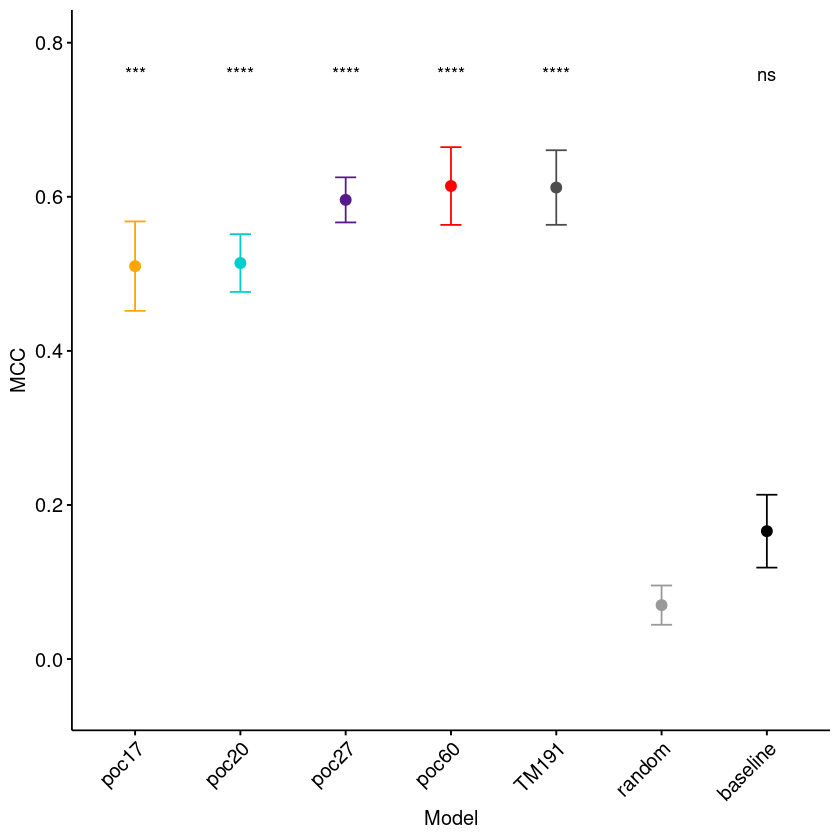

In [45]:
metrics <- c("MCC", "Precision")
models <- c(subsets, "baseline")
# Summarize the performance of all the models in a data frame
dat <- data.frame()
for (i in 1:length(models)){
    perf <- read.table(paste0("Response_to_odorants/Cross_validation/", models[i], ".tsv"),
                       sep = "\t", row.names = 1)
    perf <- subset(perf[1:5, ], select = metrics)
    dat <- rbind(dat, merge(models[i], perf))
}
names(dat) <- c("Model", metrics)

col_palette <- c('orange', 'cyan3', 'purple4', 'red', 'gray30', 'gray60', 'black')

# Plot the MCC
ggerrorplot(dat, x = "Model", y = "MCC", color = "Model", palette = col_palette,
            add = "mean", add.params = list(size = 0.5),
            error.plot = "errorbar", width = 0.2, legend = "none") + 
coord_cartesian(ylim = c(-0.05, 0.8)) + rotate_x_text(45) +
stat_compare_means(label = "p.signif", label.y = 0.75, method = "t.test", ref.group = "random")

### Evaluation:  
All the 5 models performed significantly better than the control (*random*).  
However, the differences among the 5 models are not statistically significant.  
We choose the model ***poc60***, which is a good compromise between performance and speed.

*Note:* The data contain 26% responsive (positive) OR-odorant pairs. Therefore, the ~26% `hit rate` of the control model is equivalent to a random prediction.  

## 3. Prediction of new ORs  
- Rebuild the best model above (***poc60***), with all the training data (without splitting into training & validation sets).  
- Use the model to predict the response probabilities of 416 query ORs paired with the 4 odorants (416 $\times$ 4 = 1664 pairs).  
- Repeat the prediction 3 times and rank the pairs by the average response probability.  

In [21]:
# Extract the training data columns belonging to poc60, as well as the odorant columns and the response label 
subset <- "poc60"
ResCols <- paste0("Res", as.vector(outer(get(subset), c("Comp", "Polar", "Vol"), paste0)))
datTrain <- data[, names(data) %in% c(ResCols, names(datOdor), "Label")]

# Generate the test set of OR-odorant pairs in the same format
queryORs <- readLines("Response_to_odorants/Data/Query_ORs.txt")
queryORs <- datOR[rownames(datOR) %in% queryORs, ]

testData <- data.frame()
for (cid in testCIDs){
  test <- merge(queryORs, datOdor[datOdor$CID == cid, -1])
  rownames(test) <- paste(rownames(queryORs), cid, sep = "_")
  testData <- rbind(testData, test)
}
testSet <- testData[, colnames(testData) %in% colnames(datTrain)]

# Center & scale data
preProc <- preProcess(datTrain, method = c("center", "scale"))
trainingProc <- predict(preProc, datTrain)
testProc <- predict(preProc, testSet)

# An empty data frame to store the prediction
prediction <- as.data.frame(matrix(nrow = nrow(testProc)), ncol=3)
rownames(prediction) <- rownames(testProc)

# Parameter tuning using nested 5-fold cross validation
control <- trainControl(classProbs = TRUE, 
                        method = "cv", 
                        number = 5,
                        summaryFunction = prSummary)

# Repeat 3 times the training - prediction process
for (i in 1:3){
    # Model training using the same parameter tuning procedure as above
    grid <- expand.grid(.mtry = seq(ncol(trainingProc)/2, ncol(trainingProc)-1, length.out= 5))
    mod_final <- train(data=trainingProc, Label ~ . ,
                       method="rf", ntree = 2001,
                       metric="Precision",
                       tuneGrid = grid,
                       trControl=control)
    
    # Predict the response probabilities for the test set
    probability <- predict(mod_final, newdata = testProc, type = "prob")
    prediction[, i] <- probability$positive
}

colnames(prediction) <- paste0('Prediction', 1:3)
Mean <- rowMeans(prediction)
SD <- apply(prediction, 1, sd)
prediction <- cbind(prediction, Mean, SD)
prediction <- round(prediction, 2)

# Rank by the predicted response probability
prediction <- prediction[order(prediction$Mean, decreasing = TRUE), ]

# Output to file
write.table(prediction, paste0("Response_to_odorants/Prediction/", subset, ".tsv"), sep = "\t")

### List the predicted responsive OR-odorant pairs and the ORs

In [14]:
# Pairs with response probability > 0.5
subset <- "poc60"
prediction <- read.table(paste0("Response_to_odorants/Prediction/", subset, ".tsv"), stringsAsFactors = F)
topPairs <- prediction[prediction$Mean > 0.5, ]
cat("Predicted responsive pairs: \n")
print(topPairs)

topORs <- unique(gsub("_[0-9].*", "", rownames(topPairs)))
cat("\nPredicted responsive ORs: \n", sort(topORs))

Predicted responsive pairs: 
               Replicate1 Replicate2 Replicate3 Mean   SD
Olfr885_7410         0.93       0.90       0.91 0.91 0.02
Olfr885_323          0.89       0.87       0.88 0.88 0.01
Olfr205_7410         0.87       0.84       0.84 0.85 0.02
hOR8B2_439570        0.86       0.85       0.82 0.84 0.02
Olfr194_7410         0.83       0.84       0.84 0.84 0.00
Olfr913_7410         0.84       0.81       0.82 0.82 0.01
Olfr1057_7410        0.81       0.81       0.80 0.81 0.01
Olfr251_7410         0.81       0.80       0.79 0.80 0.01
Olfr160_7410         0.80       0.80       0.80 0.80 0.00
Olfr1057_323         0.81       0.79       0.79 0.80 0.01
Olfr44_7410          0.78       0.79       0.80 0.79 0.01
Olfr199_7410         0.79       0.79       0.78 0.79 0.01
Olfr913_323          0.80       0.77       0.78 0.78 0.02
hOR1E3_7410          0.78       0.76       0.78 0.77 0.01
Olfr251_323          0.78       0.77       0.77 0.77 0.00
Olfr1057_68110       0.77       0.79       

## 4. Evaluate the prediction with *in vitro* data  
To evaluate the model performance on both classes (positive and negative), a test set of ORs underwent *in vitro* functional assays with the 4 odorants.  
The test set contained:
- all the predicted responsive ORs (the positive class),  
- randomly picked ORs from the negative class.  

In [13]:
subset <- "poc60"
# Read the in vitro response data
newPairs <- read.csv(paste0("Response_to_odorants/Data/TestSet_OR-odorant_pairs/TestSet_", subset, ".csv"),
                     stringsAsFactors = FALSE)

# Merge OR-odorant pairs
pos_pairs <- as.character()
neg_pairs <- as.character()
for (cid in testCIDs){
    # responsive ORs & pairs
    pos <- newPairs$Gene[newPairs$CID == cid & newPairs$Responsive == 1]
    pos_pairs <- c(pos_pairs, paste0(pos, "_", cid))
    # non-responsive ORs & pairs
    neg <- newPairs$Gene[newPairs$CID == cid & newPairs$Responsive == 0]
    neg_pairs <- c(neg_pairs, paste0(neg, "_", cid))
}
in_vitro <- rbind(cbind(pos_pairs, "positive"), cbind(neg_pairs, "negative"))
colnames(in_vitro) = c('Pairs', 'Label')


prediction <- read.csv(paste0("Response_to_odorants/Prediction/", subset, ".tsv"), sep = "\t")
head(prediction)
# Extract prediction on the pairs tested in vitro
testSet <- prediction[in_vitro[, "Pairs"], 4:5]
testSet$Predicted <- factor(ifelse(testSet$Mean > 0.5 , "positive", "negative"),
                           levels = c("positive", "negative"))
testSet$in_vitro <- factor(in_vitro[, "Label"], levels = c("positive", "negative"))

# Evaluate the performance on the whole test set
perfSum <- getMetrics(testSet$Predicted, testSet$in_vitro, positive = "positive")
cat(subset, "Model performance on the test set:")
perfSum

# Evaluate the performance for each odorant
for (cid in testCIDs){
    test <- testSet[grep(paste0("_", cid), rownames(testSet)), ]
    perf <- getMetrics(test$Predicted, test$in_vitro, positive = "positive")
    cat("\nModel performance on", allOdor$Odorant[match(cid, allOdor$CID)], "\n")
    print(perf)
}

,Replicate1,Replicate2,Replicate3,Mean,SD
Olfr885_7410,0.93,0.90,0.91,0.91,0.02
Olfr885_323,0.89,0.87,0.88,0.88,0.01
Olfr205_7410,0.87,0.84,0.84,0.85,0.02
hOR8B2_439570,0.86,0.85,0.82,0.84,0.02
Olfr194_7410,0.83,0.84,0.84,0.84,0.00
Olfr913_7410,0.84,0.81,0.82,0.82,0.01


poc60 Model performance on the test set:

MCC   Precision      Recall Specificity          TP          TN 
       0.37        0.44        0.53        0.86       26.00      210.00 
         FP          FN 
      33.00       23.00


Model performance on R-(-)-Carvone 
        MCC   Precision      Recall Specificity          TP          TN 
       0.40        0.56        0.42        0.93        5.00       57.00 
         FP          FN 
       4.00        7.00 

Model performance on acetophenone 
        MCC   Precision      Recall Specificity          TP          TN 
       0.32        0.33        0.64        0.77        7.00       48.00 
         FP          FN 
      14.00        4.00 

Model performance on coumarin 
        MCC   Precision      Recall Specificity          TP          TN 
       0.34        0.44        0.53        0.83        8.00       48.00 
         FP          FN 
      10.00        7.00 

Model performance on 4-chromanone 
        MCC   Precision      Recall Specificity          TP          TN 
       0.46        0.55        0.55        0.92        6.00       57.00 
         FP          FN 
       5.00        5.00 
